##Catboost with PCA(100) on Image and Text Embeddings 


Submitted by Akriti Gupta, Bhumika Singhal and Namita Shukla

In [1]:
!pip install catboost

     |████████████████████████████████| 76.6 MB 43 kB/s 


In [2]:
#  Here we make all the imports required 
import pandas as pd
import numpy as np
import random, time
import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix
from tqdm.notebook import tqdm, trange
import json

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot


In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Importing all the Concat Embeddings of Text and Images reducing them to 100 dim using PCA. 

In [4]:
concat_embeddings = pd.read_csv("/content/gdrive/MyDrive/522-project/Embeddings/cocat_pca_embed/ConcatEmbeddings100_train.csv")
concat_embeddings.rename(columns={"0": "id"}, inplace=True)

In [5]:
concat_embeddings_val = pd.read_csv("/content/gdrive/MyDrive/522-project/Embeddings/cocat_pca_embed/ConcatEmbeddings100_dev_unseen.csv")
concat_embeddings_val.rename(columns={"0": "id"}, inplace=True)

In [6]:
concat_embeddings_test_unseen = pd.read_csv("/content/gdrive/MyDrive/522-project/Embeddings/cocat_pca_embed/ConcatEmbeddings100_test_unseen.csv")
concat_embeddings_test_unseen.rename(columns={"0": "id"}, inplace=True)
concat_embeddings_test_seen = pd.read_csv("/content/gdrive/MyDrive/522-project/Embeddings/cocat_pca_embed/ConcatEmbeddings100_test_seen.csv")
concat_embeddings_test_seen.rename(columns={"0": "id"}, inplace=True)

Importing all the JSON Files 

In [7]:
train_data = pd.read_json("/content/gdrive/MyDrive/522-project/train.jsonl", lines=True)
train_data.head()
train_data.shape
# batch_size = 32
# chunked_data = split_dataframe(train_data, batch_size)

(8500, 4)

In [8]:
val_data = pd.read_json("/content/gdrive/MyDrive/522-project/dev_unseen.jsonl", lines=True)
val_data.head()
val_data.shape

(540, 4)

In [9]:
test_unseen_data = pd.read_json("/content/gdrive/MyDrive/522-project/test_unseen.jsonl", lines=True)
test_unseen_data.head()
test_unseen_data.shape

(2000, 4)

In [10]:
test_seen_data = pd.read_json("/content/gdrive/MyDrive/522-project/test_seen.jsonl", lines=True)
test_seen_data.head()
test_seen_data.shape

(1000, 4)

In [11]:
train_embed = concat_embeddings[concat_embeddings.id.isin(train_data.id)].concat_embeddings.apply(lambda x : json.loads(x)).tolist()
target_train = train_data["label"].tolist()
print(len(train_embed))

8500


In [12]:
val_embed= concat_embeddings_val[concat_embeddings_val.id.isin(val_data.id)].concat_embeddings.apply(lambda x : json.loads(x)).tolist()
val_target = val_data["label"].tolist()
len(val_embed)

540

In [14]:
test_unseen_embed= concat_embeddings_test_unseen[concat_embeddings_test_unseen.id.isin(test_unseen_data.id)].concat_embeddings.apply(lambda x : json.loads(x)).tolist()
test_unseen_target = test_unseen_data["label"].tolist()
len(test_unseen_embed)
len(test_unseen_target)

2000

In [13]:
test_seen_embed= concat_embeddings_test_seen[concat_embeddings_test_seen.id.isin(test_seen_data.id)].concat_embeddings.apply(lambda x : json.loads(x)).tolist()
test_seen_target = test_seen_data["label"].tolist()
len(test_seen_embed)

1000

## Fitting the cocatenated Train embedding on the Catboost Model

We fine tuned the catboost model on various parameters such as :  

1. training iterations
2. regularization penalties of l2.
3. iterations
4. learning rate



In [15]:
train_embed = np.array(train_embed)
target_train = np.array(target_train)
val_embed = np.array(val_embed)
val_target = np.array(val_target)

In [16]:
import sklearn.metrics as metrics
clf = CatBoostClassifier(
    iterations=100, 
    learning_rate=0.5, 
    loss_function='CrossEntropy',
    depth=3,
    l2_leaf_reg = 2,
    grow_policy= "Depthwise",
    random_strength = 0.1,
    od_type = 'IncToDec'  
)

clf.fit(train_embed, target_train)
# pred_y_cb_val = clf.predict(val_embed)
# pred_y_cb_train =  clf.predict(train_embed)

0:	learn: 0.6180056	total: 111ms	remaining: 11s
1:	learn: 0.5942090	total: 195ms	remaining: 9.57s
2:	learn: 0.5810323	total: 261ms	remaining: 8.45s
3:	learn: 0.5707786	total: 330ms	remaining: 7.91s
4:	learn: 0.5627097	total: 393ms	remaining: 7.47s
5:	learn: 0.5560229	total: 468ms	remaining: 7.33s
6:	learn: 0.5502962	total: 537ms	remaining: 7.13s
7:	learn: 0.5447163	total: 602ms	remaining: 6.93s
8:	learn: 0.5388965	total: 689ms	remaining: 6.97s
9:	learn: 0.5328926	total: 765ms	remaining: 6.89s
10:	learn: 0.5276966	total: 869ms	remaining: 7.03s
11:	learn: 0.5221084	total: 939ms	remaining: 6.88s
12:	learn: 0.5162763	total: 1.04s	remaining: 6.99s
13:	learn: 0.5120482	total: 1.14s	remaining: 7.03s
14:	learn: 0.5070402	total: 1.23s	remaining: 6.96s
15:	learn: 0.5016810	total: 1.3s	remaining: 6.82s
16:	learn: 0.4978156	total: 1.34s	remaining: 6.55s
17:	learn: 0.4943986	total: 1.38s	remaining: 6.29s
18:	learn: 0.4891343	total: 1.44s	remaining: 6.13s
19:	learn: 0.4847198	total: 1.49s	remaining:

## Testing on the Validation Set

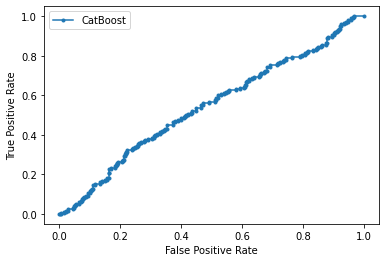

precision :0.43859649122807015 recall :0.375 f1 :0.4043126684636118 accuracy :0.5907407407407408


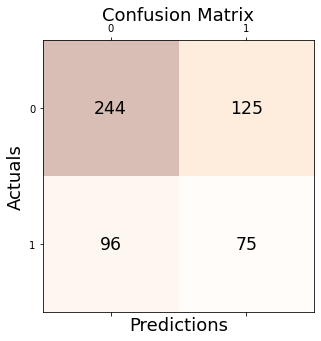

Precision vs Recall


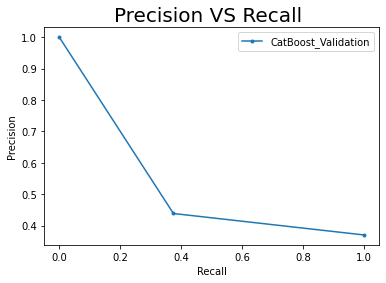

In [17]:
preds = clf.predict(val_embed)
lr_probs = clf.predict_proba(val_embed) 
lr_probs = lr_probs[:, 1]

lr_auc = roc_auc_score(val_target, lr_probs)
lr_fpr, lr_tpr, _ = roc_curve(val_target, lr_probs)
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='CatBoost')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
precision, recall, f1, _ = precision_recall_fscore_support(val_target, preds, average='binary')
acc = accuracy_score(val_target, preds)
r = confusion_matrix(preds, val_target)
print("precision :"+str(precision) +" recall :"+str(recall)+" f1 :"+ str(f1)  + " accuracy :" + str(acc))

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(r, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(r.shape[0]):
    for j in range(r.shape[1]):
        ax.text(x=j, y=i,s=r[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
print("Precision vs Recall")
precision1, recall1, thresholds = precision_recall_curve(val_target, preds)
pyplot.plot(recall1, precision1, marker='.', label='CatBoost_Validation')
# axis labels
pyplot.title('Precision VS Recall ', fontsize=20)
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

In [18]:
print("ROC Curve : " + str(lr_auc))

ROC Curve : 0.5431176470588235


## Testing on Test Seen Data

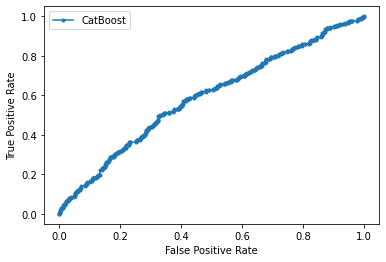

precision :0.6007194244604317 recall :0.3408163265306122 f1 :0.4348958333333333 accuracy :0.566


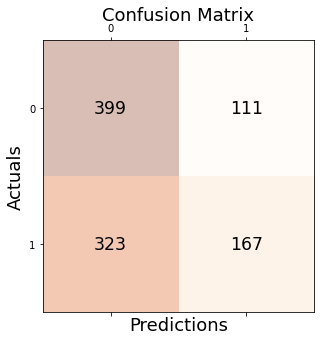

Precision vs Recall


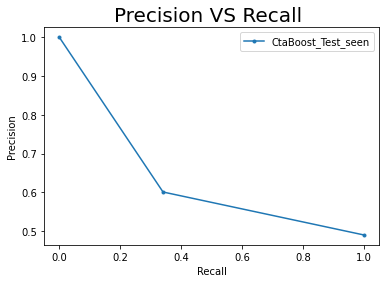

In [19]:
preds = clf.predict(test_seen_embed)
lr_probs = clf.predict_proba(test_seen_embed) 
lr_probs = lr_probs[:, 1]

lr_auc = roc_auc_score(test_seen_target, lr_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_seen_target, lr_probs)
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='CatBoost')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
precision, recall, f1, _ = precision_recall_fscore_support(test_seen_target, preds, average='binary')
acc = accuracy_score(test_seen_target, preds)

r = confusion_matrix(test_seen_target, preds)
print("precision :"+str(precision) +" recall :"+str(recall)+" f1 :"+ str(f1)  + " accuracy :" + str(acc))

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(r, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(r.shape[0]):
    for j in range(r.shape[1]):
        ax.text(x=j, y=i,s=r[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
print("Precision vs Recall")
precision1, recall1, thresholds = precision_recall_curve(test_seen_target, preds)
pyplot.plot(recall1, precision1, marker='.', label='CtaBoost_Test_seen')
# axis labels
pyplot.title('Precision VS Recall ', fontsize=20)
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

In [20]:
print("ROC Curve : " + str(lr_auc))

ROC Curve : 0.5908363345338136


## Testing on the unseen test data

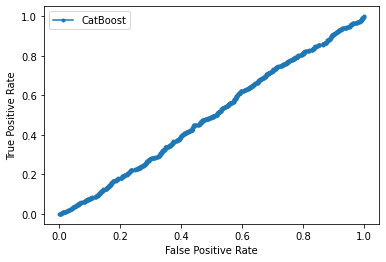

precision :0.3613193403298351 recall :0.32133333333333336 f1 :0.34015525758645027 accuracy :0.5325


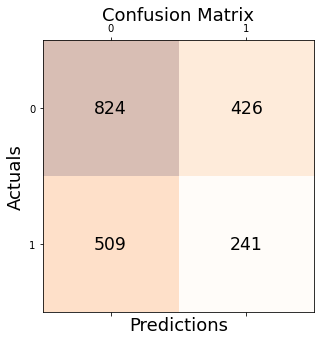

Precision vs Recall


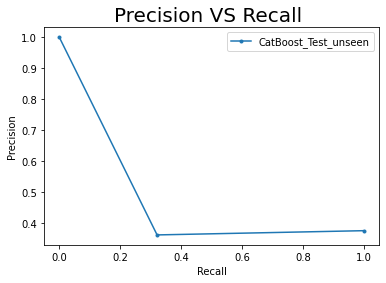

In [21]:
preds = clf.predict(test_unseen_embed)
lr_probs = clf.predict_proba(test_unseen_embed) 
lr_probs = lr_probs[:, 1]

lr_auc = roc_auc_score(test_unseen_target, lr_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_unseen_target, lr_probs)
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='CatBoost')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
precision, recall, f1, _ = precision_recall_fscore_support(test_unseen_target, preds, average='binary')
acc = accuracy_score(test_unseen_target, preds)
r = confusion_matrix(test_unseen_target, preds)
print("precision :"+str(precision) +" recall :"+str(recall)+" f1 :"+ str(f1)  + " accuracy :" + str(acc))

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(r, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(r.shape[0]):
    for j in range(r.shape[1]):
        ax.text(x=j, y=i,s=r[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

precision1, recall1, thresholds = precision_recall_curve(test_unseen_target, preds)
print("Precision vs Recall")
pyplot.plot(recall1, precision1, marker='.', label='CatBoost_Test_unseen')
# axis labels
pyplot.title('Precision VS Recall ', fontsize=20)
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

In [22]:
print("ROC Curve : " + str(lr_auc))

ROC Curve : 0.4953898666666666
